# CNN Implementation and Experiments

This notebook demonstrates the CNN implementation and experiments for the IF3270 Machine Learning assignment. We'll work with the CIFAR-10 dataset to perform image classification.

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from sklearn.metrics import f1_score, classification_report

# Add the parent directory to the path to import our modules
sys.path.append('..')

from src.CNN.cifar10_loader import CIFAR10Loader
from src.CNN.experiments import CNNExperiments
from src.CNN.cnn_model import CNNModel
from src.CNN.layers.conv_layer import ConvLayer
from src.CNN.layers.pooling_layer import PoolingLayer
from src.CNN.layers.flatten_layer import FlattenLayer
from src.Base.layers.dense_layer import DenseLayer
from src.Base.layers.activation_layer import ReLU, Softmax
from src.Base.utils.evaluation import compare_keras_vs_scratch
from src.Base.utils.visualization import plot_training_history, visualize_feature_maps

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available!")
    gpu_device = tf.config.list_physical_devices('GPU')[0]
    try:
        # Configure TensorFlow to use memory growth instead of pre-allocating all memory
        tf.config.experimental.set_memory_growth(gpu_device, True)
        print("Memory growth enabled")
    except:
        # Or you can limit GPU memory usage
        tf.config.set_logical_device_configuration(
            gpu_device,
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
        )
        print("GPU memory limited to 4GB")
else:
    print("No GPU found, using CPU instead")

Num GPUs Available:  0
No GPU found, using CPU instead


## 1. Load and Explore the CIFAR-10 Dataset

CIFAR-10 loaded with splits:
  Training: 40000 images
  Validation: 10000 images
  Test: 10000 images


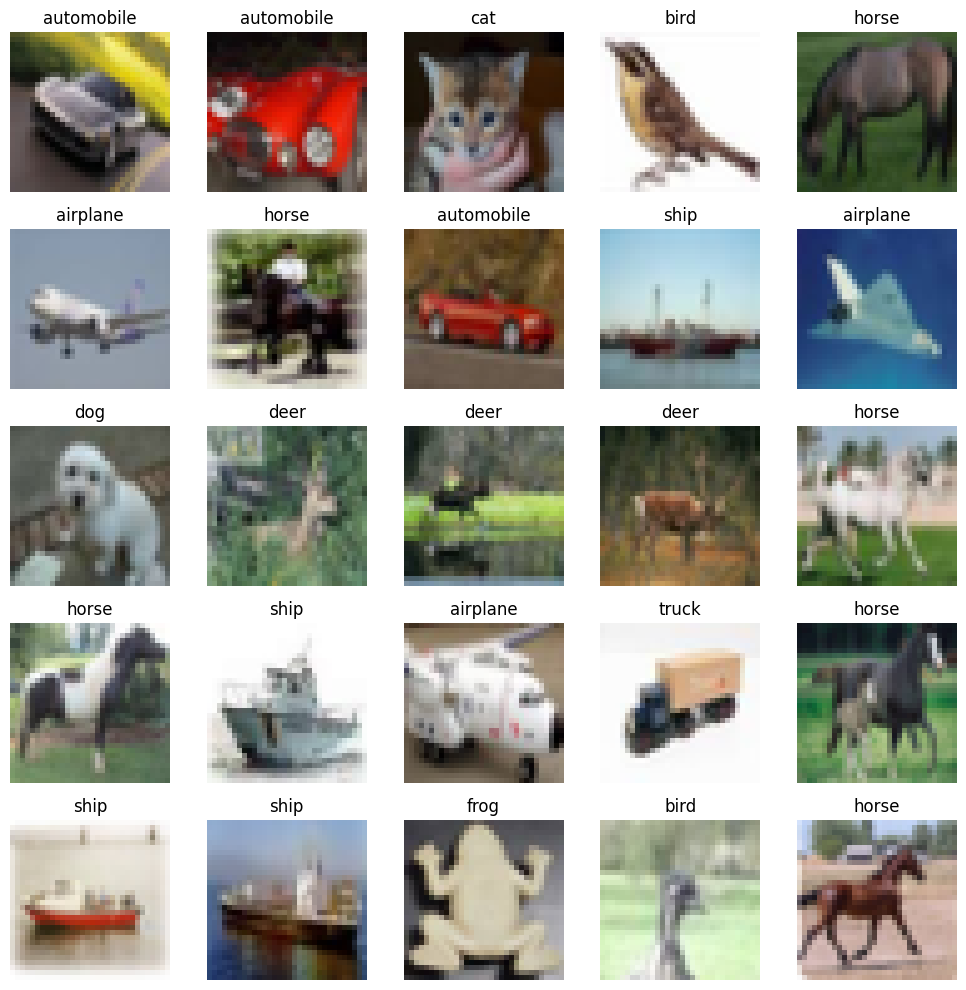

In [6]:
# Initialize the data loader
data_loader = CIFAR10Loader(batch_size=64)

# Get a batch of training data for visualization
train_dataset = data_loader.get_dataset('train')
for images, labels in train_dataset.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()
    break

# Visualize a few sample images
plt.figure(figsize=(10, 10))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(class_names[sample_labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Hyperparameter Experiments with CNN

We'll run experiments to analyze the impact of different hyperparameters on CNN performance.

In [7]:
# Initialize the experiments class
experiments = CNNExperiments(batch_size=64, epochs=15)

CIFAR-10 loaded with splits:
  Training: 40000 images
  Validation: 10000 images
  Test: 10000 images


### 2.1 Experiment: Number of Convolutional Layers

In [8]:
# Define variants for number of convolutional layers
conv_layer_variants = [
    (2, "2 Conv Layers"),
    (3, "3 Conv Layers"),
    (4, "4 Conv Layers")
]

# Run experiment
conv_layer_models, conv_layer_histories = experiments.run_conv_layers_experiment(conv_layer_variants)

Running experiments for different numbers of convolutional layers...

Training model with 2 Conv Layers...


c:\Users\Shafi\Documents\Works\Informatika\Semester 6\ML\Tubes 2\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
150/625 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2.1495 - sparse_categorical_accuracy: 0.1915

KeyboardInterrupt: 

### 2.2 Experiment: Number of Filters per Layer

In [ ]:
# Define variants for filter counts
filter_count_variants = [
    ([16, 32, 64], "Small Filter Counts"),
    ([32, 64, 128], "Medium Filter Counts"),
    ([64, 128, 256], "Large Filter Counts")
]

# Run experiment
filter_count_models, filter_count_histories = experiments.run_filter_count_experiment(filter_count_variants)

### 2.3 Experiment: Filter Sizes

In [ ]:
# Define variants for filter sizes
filter_size_variants = [
    ([(3, 3), (3, 3), (3, 3)], "3x3 Filters"),
    ([(5, 5), (3, 3), (3, 3)], "5x5 + 3x3 Filters"),
    ([(7, 7), (5, 5), (3, 3)], "7x7 + 5x5 + 3x3 Filters")
]

# Run experiment
filter_size_models, filter_size_histories = experiments.run_filter_size_experiment(filter_size_variants)

### 2.4 Experiment: Pooling Types

In [ ]:
# Define variants for pooling types
pooling_variants = [
    (MaxPooling2D, "Max Pooling"),
    (AveragePooling2D, "Average Pooling")
]

# Run experiment
pooling_models, pooling_histories = experiments.run_pooling_type_experiment(pooling_variants)

## 3. From-Scratch CNN Implementation

Now we'll implement the CNN forward propagation from scratch and compare it with the Keras implementation.

### 3.1 Choose and Save a Keras Model

In [ ]:
# Choose one of the trained models (e.g., from conv layers experiment)
keras_model = conv_layer_models[1][0]  # 3 Conv Layers model

# Summary of the chosen model
keras_model.summary()

# Save the model weights
keras_model.save_weights('cnn_model_weights.h5')

### 3.2 Create From-Scratch CNN Model

In [ ]:
# Create a from-scratch CNN model that matches the Keras model
scratch_model = CNNModel()

# Add layers corresponding to the Keras model architecture
scratch_model.add(ConvLayer(in_channels=3, out_channels=32, kernel_size=3, padding=1))
scratch_model.add(ReLU())
scratch_model.add(PoolingLayer(pool_size=2, stride=2, pool_type='max'))

scratch_model.add(ConvLayer(in_channels=32, out_channels=64, kernel_size=3, padding=1))
scratch_model.add(ReLU())
scratch_model.add(PoolingLayer(pool_size=2, stride=2, pool_type='max'))

scratch_model.add(ConvLayer(in_channels=64, out_channels=128, kernel_size=3, padding=1))
scratch_model.add(ReLU())
scratch_model.add(PoolingLayer(pool_size=2, stride=2, pool_type='max'))

scratch_model.add(FlattenLayer())
scratch_model.add(DenseLayer(input_dim=2048, output_dim=128, activation=ReLU()))
scratch_model.add(DenseLayer(input_dim=128, output_dim=10, activation=Softmax()))

### 3.3 Load Weights from Keras Model

In [ ]:
# Load weights from the Keras model
scratch_model.load_weights_from_keras(keras_model)

print("Weights loaded from Keras model to from-scratch implementation.")

### 3.4 Compare Predictions from Keras and From-Scratch Models

In [ ]:
# Get test data
x_test, y_test = data_loader.get_numpy_data('test')

# Compare predictions
comparison = compare_keras_vs_scratch(keras_model, scratch_model, x_test, y_test, batch_size=64)

print("\nKeras Model Metrics:")
print(f"Accuracy: {comparison['keras_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['keras_metrics']['macro_f1']:.4f}")

print("\nFrom-Scratch Model Metrics:")
print(f"Accuracy: {comparison['scratch_metrics']['accuracy']:.4f}")
print(f"Macro F1-Score: {comparison['scratch_metrics']['macro_f1']:.4f}")

print(f"\nModel Agreement: {comparison['model_agreement']:.4f}")

### 3.5 Visualize Predictions on Sample Images

In [ ]:
# Get a few test images
num_samples = 10
sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
sample_images = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# Make predictions with both models
keras_preds = np.argmax(keras_model.predict(sample_images), axis=1)
scratch_preds = scratch_model.predict(sample_images)

# Visualize the results
plt.figure(figsize=(15, 8))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    
    # Show true label and predictions
    keras_correct = keras_preds[i] == sample_labels[i]
    scratch_correct = scratch_preds[i] == sample_labels[i]
    
    title = f"True: {class_names[sample_labels[i]]}\n"
    title += f"Keras: {class_names[keras_preds[i]]} {'✓' if keras_correct else '✗'}\n"
    title += f"Scratch: {class_names[scratch_preds[i]]} {'✓' if scratch_correct else '✗'}"
    
    plt.title(title, fontsize=9)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## 4. Analysis and Conclusions

Based on our experiments, we can draw the following conclusions about CNN hyperparameters:

### 4.1 Effect of Number of Convolutional Layers

[Placeholder for your analysis]

### 4.2 Effect of Filter Counts per Layer

[Placeholder for your analysis]

### 4.3 Effect of Filter Sizes

[Placeholder for your analysis]

### 4.4 Effect of Pooling Type

[Placeholder for your analysis]

### 4.5 From-Scratch Implementation Analysis

[Placeholder for your analysis of the from-scratch implementation compared to Keras]